<img src="PolyMTL_Logo.JPG" alt="Drawing" style="width: 400px; height: 300px"/>

# INF8215 - Intelligence artif.: méthodes et algorithmes
## TP3
##### Equipe MMA - Manu Serpette 2229693 - Marc-Antoine Bettez 1828113 - Allen Yu 1958185


---
## Feature design



- Choix des attributs

> <p style="text-align:justify;">Afin de choisir quels attributs du <i>dataset</i> sont pertinent pour la détection d'url de <i>phishing</i>, nous avons calculé la matrice de corrélation des attributs du <i>set</i></p>

> <p style="text-align:justify;">De plus, après avoir éliminé les attributs non numérique et afin de favoriser la précision du modèle, nous avons normalisé entre 0 et 1 les attributs restantsé. Cette approche permet d'éviter les biais où une <i>feature</i> pourrait prédominé sur les autres.</p>

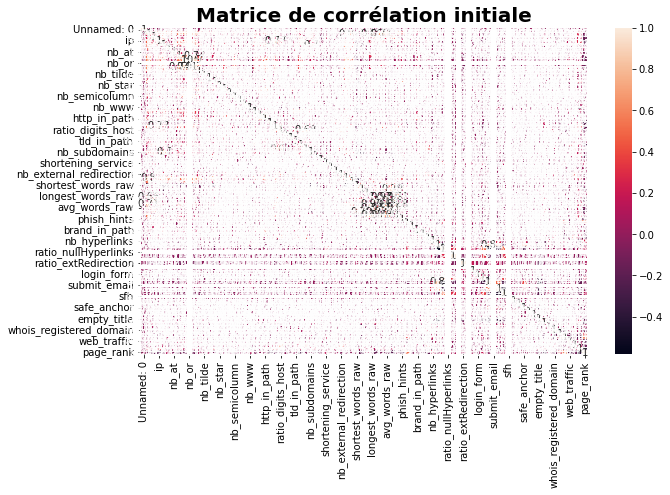

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Make NumPy printouts easier to read.
fig, ax = plt.subplots()
ax.set_title("Matrice de corrélation initiale", fontsize=20, fontweight='bold')
fig.set_size_inches(10, 6)
np.set_printoptions(precision=3, suppress=True)
df2 = pd.read_csv("train.csv", header=0)
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

def filter(L):
    res = []
    for i in L:
        if i > 0.5:
            res.append(1)
        else:
            res.append(0)
    return res


def compute_accuracy(Y_true, Y_pred):
    correctly_predicted = 0
    # iterating over every label and checking it with the true sample
    for true_label, predicted in zip(Y_true, Y_pred):
        if true_label == predicted:
            correctly_predicted += 1
    # computing the accuracy score
    accuracy_score = correctly_predicted / len(Y_true)
    return accuracy_score


- <p style="text-align:justify;">A l'aide de la matrice de corrélation, ci-dessus, et de ce qu'il nous semblait pertinent au regard de la détection d'URLs de <i>phishing</i>, nous avons sélectionné certaines <i>features</i> du jeu de données. Dans la matrice de corrélation, ci-dessus, nous avons enlevé les <i>features</i> qui ont une très faible correlation avec les autres <i>features</i>.</p>

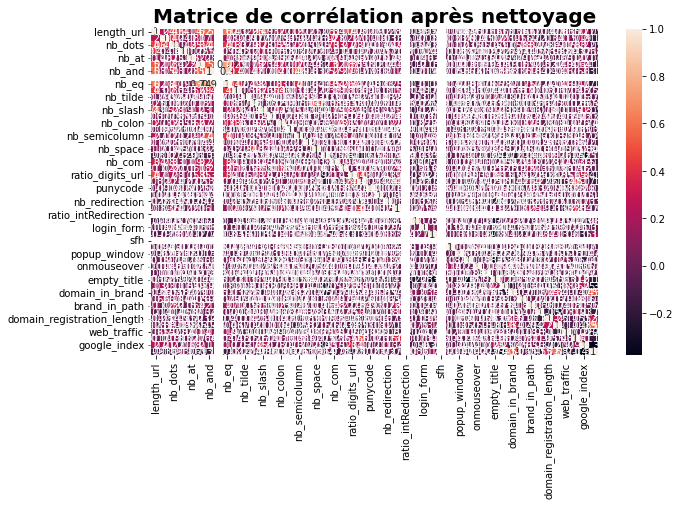

In [27]:
def build_set(path):
    df = pd.read_csv(path, header=0)
    selected_columns = ['length_url', 'length_hostname', "nb_dots", "nb_hyphens", "nb_at", "nb_qm", "nb_and", "nb_or",
                        "nb_eq", "nb_underscore", "nb_tilde", "nb_percent", "nb_slash", "nb_star", "nb_colon",
                        "nb_comma", "nb_semicolumn", "nb_dollar", "nb_space", "nb_www", "nb_com", "nb_dslash",
                        "ratio_digits_url", "ratio_digits_host", "punycode", "path_extension", "nb_redirection",
                        "nb_external_redirection",
                        "ratio_intRedirection", "ratio_extRedirection", "login_form", "external_favicon", "sfh",
                        "iframe", "popup_window", "safe_anchor", "onmouseover", "right_clic", "empty_title",
                        "domain_in_title", "domain_in_brand", "brand_in_subdomain", "brand_in_path",
                        "whois_registered_domain", "domain_registration_length", "domain_age", "web_traffic",
                        "dns_record", "google_index", "page_rank"]
    x = df[selected_columns]
    x = df._get_numeric_data()
    x = x.drop(columns=['Unnamed: 0'])
    x = x.to_numpy()
    x = normalize(x, axis=0)
    y = df["status"].map({'legitimate': 0, 'phishing': 1})
    corr_matrix = df2[selected_columns].corr()
    fig2, ax2 = plt.subplots()
    fig2.set_size_inches(10, 6)
    ax2.set_title("Matrice de corrélation après nettoyage", fontsize=20, fontweight='bold')
    sns.heatmap(corr_matrix, annot=True)
    plt.show()
    return x, y

# Define Grid
x_train, y_train = build_set("train.csv")
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.3, shuffle=True)



- <p style="text-align:justify;">Sur la nouvelle matrice de corrélation, ci-dessus, l'on voit que globalement nos <i>features</i> sont en moyenne plus corrélés aux autres que sur la première matrice. Notre choix de <i>features</i> est donc pertinent, mais pourrait avec plus de temps être améliorée pour maximiser la <i>cross</i> corrélation. Par exemple, utiliser une analyse en composantes principales pourrait permettre d'extraire un nouvel ensemble de <i>features</i> minimals et qui maximisent la pertinence de ces dernières.</p>

## Méthodologie

- Répartition des données

> <p style="text-align:justify;">Nous avons réalisé une répartition comme suit: 70% des données pour l'entrainement et 30% pour tester le modèle. Cette séparation de l'exemplaire permet de detecter un <i>overfit</i> du modèle</p>

> <p style="text-align:justify;">Le dataset contient 4629 url legitime et 3543 url compromises, on peut dire que l'exemplaire est plutôt équilibré, nous avons donc choisi de ne pas reéquilibré ce dernier.</p>

- Choix du modèle

> <p style="text-align:justify;">Après lecture d'un article, [1].  Nous avons choisi d'utiliser un <i>Random Forest Classifier</i>. Celui-ci étant un modèle délivrant le plus de résultats pour ce genre d'exercice. Et ce notamment, étant basé sur plusieurs arbres de décision, grace à leurs haute précision, faible biais et capacité de scaling sur de grands exemplaires de données.</p>



- <i>Tuning</i> des hyperparamètres


<p style="text-align:justify;">Afin de déterminer les hyper paramètre optimaux, nous effectuons un <i>GridSearch</i> sur les paramètres suivant:</p>

        - Le nombre d'estimateurs, représentant les multiple arbres de décision de la forêt 
        - La fonction pour le calcul du nombre d'attributs à regarder
        - La profondeur de l'arbre

<p style="text-align:justify;">Nous utilisons <i>GridSearch</i> sur la précision, car cela nous permettera de maximiser les hyper paramètres de notre modèle et ainsi facilement reconstruire notre modèle une fois ces paramètres trouvés.</p>
<p style="text-align:justify;">Nous spécifions des intervalles pour chaques paramètres, si le résultat du <i>GridSearch</i> tombe sur une borne nous étendons l'intervalle et ainsi de suite.</p>

In [13]:
grid = {
    'n_estimators': [400,500,600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400],
    'max_features': ['sqrt'],
    'max_depth': [16, 18, 20, 24, 28, 30, 32],
    'random_state': [18]
}

In [14]:
CV_rfr = GridSearchCV(estimator=RandomForestClassifier(),
                      param_grid=grid, cv=5, verbose=10, n_jobs=-1)
CV_rfr.fit(x_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [16, 18, 20, 24, 28, 30, 32],
                         'max_features': ['sqrt'],
                         'n_estimators': [400, 500, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000, 2200, 2400],
                         'random_state': [18]},
             verbose=10)

Les hyper paramètres optimaux trouvés par le grid search sont les suivants:

In [15]:
print("\n The best parameters across ALL searched params:\n", CV_rfr.best_params_)


 The best parameters across ALL searched params:
 {'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 1400, 'random_state': 18}


- <p style="text-align:justify;">On remarque que le <i>GridSearch</i> propose une profondeur de 24. Cela représente un arbre plutôt profond et l'on pourrait s'attendre à de l'<i>overfitting</i> malgré la grande précision obtenue sur le jeu d'entrainement (0.97). Cependant, le nombre d'estimateurs proposé est de 600, ce qui est important. Ce nombre d'arbres de décisions élevé augmentera considérablement le temps d'entrainement, mais permetterait de réduire l'<i>overfitting</i>. L'on peut donc espérer que les deux effets se composereront et que notre modèle sera de grande précision sur le jeu de test.</p>


- <p style="text-align:justify;">On peut maintenant demander au modèle, en lui appliquant les paramètres precèdents, de réaliser une prédiction sur le jeu de test pour obtenir la précision du modèle et la matrice de confusion associée à l'exemplaire.</p>

In [16]:
prediction = filter(CV_rfr.predict(x_test))

In [17]:
print("Accuracy: ", compute_accuracy(y_test, prediction))

Accuracy:  0.9653344208809136


- <p style="text-align:justify;">Nous obtenons sur l'exemplaire de test une précision très élevée et proche de la précision d'entrainement. Nous pouvons donc conclure que notre modèle est pertinent et qu'il <i>overfit</i> très peu.</p>

## Résultats

- Matrice de confusion:

La matrice de confusion nous donne le nombre de faux positifs et de faux négatifs du modèle:

In [18]:
#code matrice de confusion
print(confusion_matrix(filter(y_test), prediction))

[[1336   45]
 [  40 1031]]


- <p style="text-align:justify;">On remarque que sur plus de 2300 urls testées seulement 87 URLs ont été mal classifiées. On peut donc considérer que le filtre est utilisable en pratique, car il protégera l'utilisateur contre une grande majorité des menaces.</p>

### Analyse des résultats de la matrice de confusion

- <p style="text-align:justify;">Afin d'analyser en détails notre modèle, nous avons construis un graphique représentant la précision de l'arbre en fonction des paramètres du <i>GridSearch</i></p>

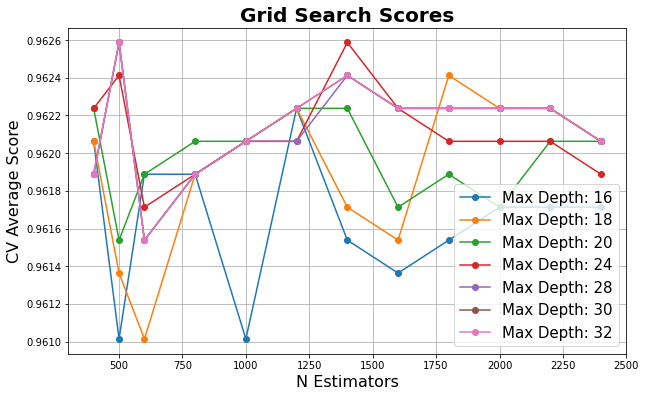

In [20]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)
    
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    plt.show()
plot_grid_search(CV_rfr.cv_results_, grid['n_estimators'], grid['max_depth'], 'N Estimators', 'Max Depth')

<p style="text-align:justify;">Ce graph illustre bien le choix de paramètre du <i>GridSearch</i>. On remarque en effet qu'il a bien choisi le couple permettant de maximiser la métrique, qui ici est la précision ( Nous avons choisi la même métrique que sur Kaggle ).</p>

## Résultat sur Kaggle

<p style="text-align:justify;">Après avoir envoyé notre prédiction sur Kaggle, nous obtenons une précision de 0.95 soit 0.01 en dessous de ce que nous avion sur notre machine. Ainsi, nous sommes donc confiant que notre modèle n'est pas en surapprentissage. Le résultat est 0.04 au dessus de la <i>baseline</i>, nous sommes donc satisfait par ce modèle.</p>

## Discussion

<p style="text-align:justify;"> Pour conclure sur les méthodes utilisées, après expérimentation, nous avons vu une légère amélioration des résultats en utilisant la normalisation et le choix de <i>features</i>.</p>

<p style="text-align:justify;"> L'utilisation de <i>GridSearch</i> est ,quant à elle, fidèle à sa promesse est délivre bien le meilleurs choix de paramètres possible parmis ceux qui lui sont fournis. Un défaut de cette méthode serait son temps d'exécution. La consommation en temps explose combinatoirement avec le nombre de paramètres choisis. Dans le cas présent nous avons que $GridSearch \in O\left(mnk\right)$ où $m$ est <i>n_estimators</i>, $n$ est <i>max_features</i> et $k$ est <i>max_depth</i>. Avec un choix avertis, l'on peut réduire la consommation en temps de cette recherche en sélectionnant les bons hyper-paramètres à tester.</p>

<p style="text-align:justify;"> Pour améliorer nos résultats il serait intéressant d'affiner le choix de <i>features</i>, par exemple en maximisant la corrélation moyenne de la matrice post sélection ou encore en utilisant une ACP pour générer des <i>features</i> plus pertinentes. Il serait évidemment intéressant de tester d'autre modèles, comme par exemple le ADAboost, XGboost, la régression logistique ou même des réseaux de neurones.


## Références

[[1]Shahrivari, Vahid & Darabi, Mohammad & Izadi, Mohammad. (2020). Phishing Detection Using Machine Learning Techniques.](https://arxiv.org/pdf/2009.11116.pdf)